# Import Library

In [1]:
import math
import os
import random
import pickle
import itertools
import numpy as np 
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 
from sklearn.utils import shuffle
from scipy.signal import resample
import matplotlib.pyplot as plt
np.random.seed(42)
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Load Data

In [41]:
df = pd.read_csv("Data\mitbih_train.csv", header=None)
df2 = pd.read_csv("Data\mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [42]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [44]:
df[187].value_counts()

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64

In [45]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [46]:
del df
del df2
del M

# visualisasi data

In [47]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

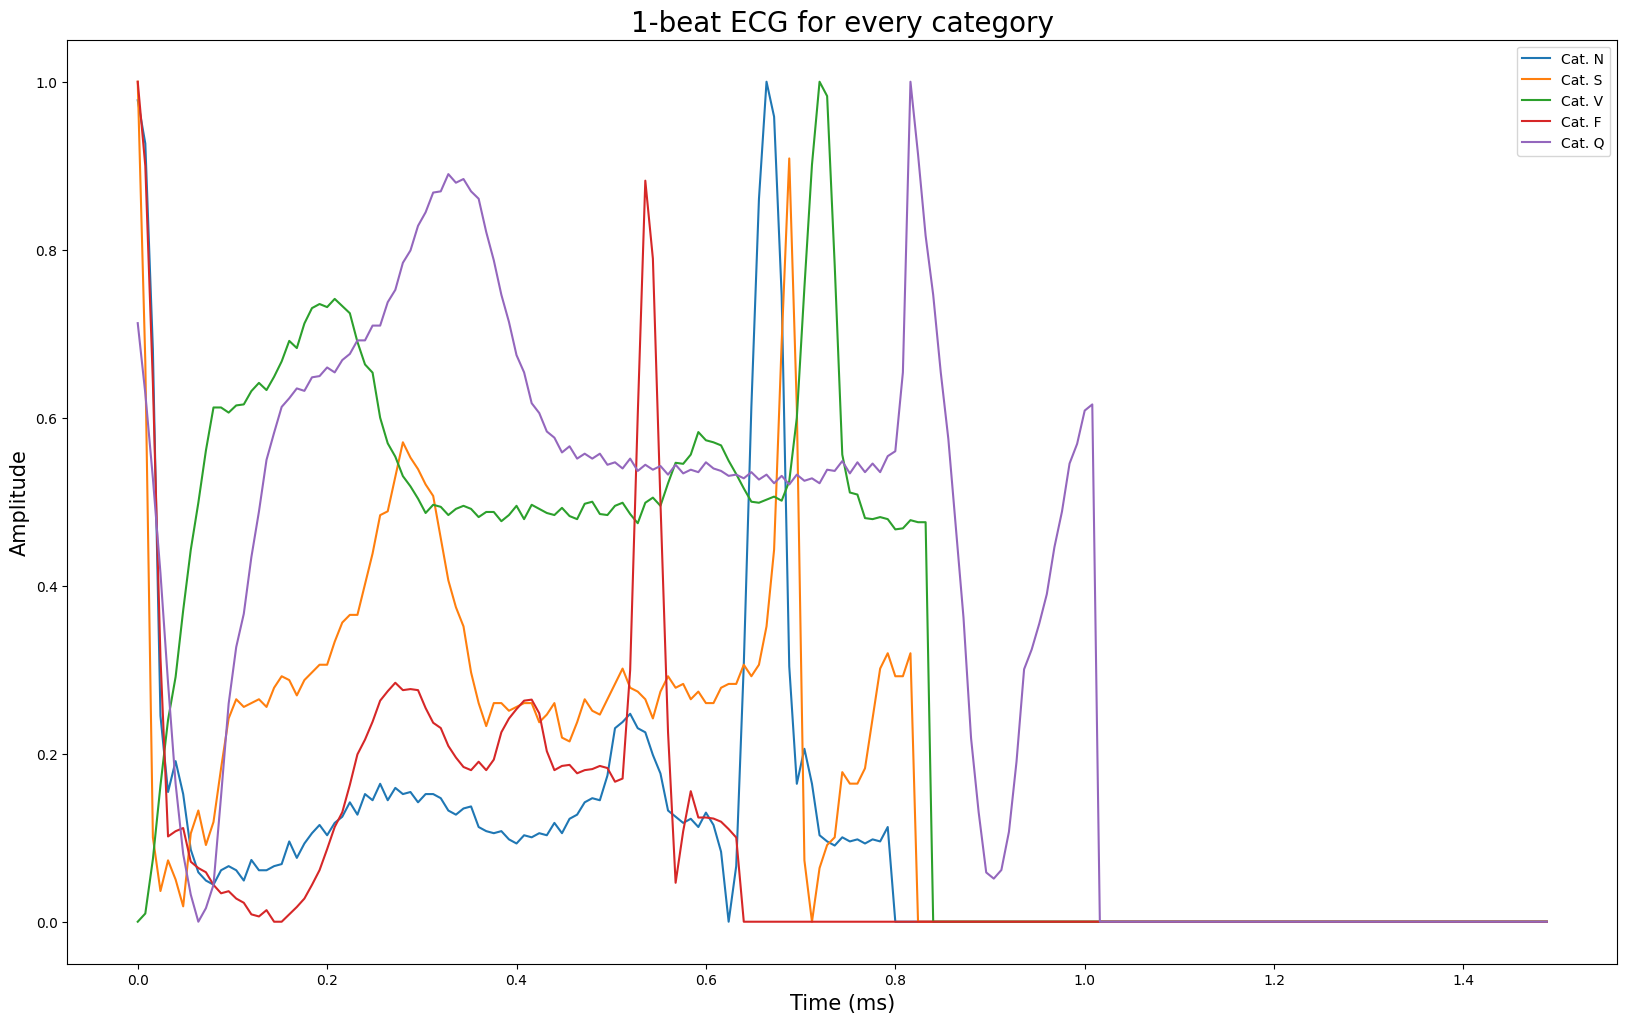

In [48]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# Data Augmentaion

Untuk melatih model dengan benar, kita harus menambah semua data ke tingkat yang sama.untuk percobaan pertama, kami hanya akan menambah kelas terkecil ke level yang sama dengan kelas 1. Dengan itu kami akan dapat melakukan serangkaian pengujian sekitar 5x800 observasi.

In [12]:

def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

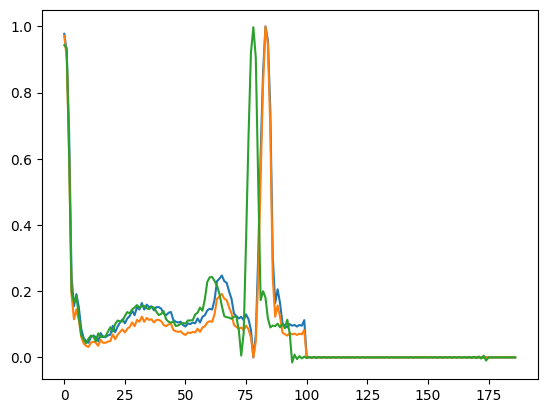

In [13]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [14]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

# Split

In [15]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [16]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [17]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [18]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [19]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [20]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# Model

In [21]:
n_obs, feature, depth = X_train.shape
batch_size = 500


In [22]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate



In [23]:
lrate = LearningRateScheduler(exp_decay)

In [24]:
# Assuming y_train is a csr_matrix
y_train_dense = y_train.toarray()
y_test_dense = y_test.toarray()

In [25]:
from keras.layers import Input, Dense, Flatten, Activation
from keras.models import Model
from keras.optimizers import Adam

# Model definition
inp = Input(shape=(feature, depth))
F1 = Flatten()(inp)

D1 = Dense(64)(F1)
A1 = Activation("relu")(D1)

D2 = Dense(64)(A1)
A2 = Activation("relu")(D2)

# Additional hidden layer
D3 = Dense(32)(A2)
A3 = Activation("relu")(D3)

D4 = Dense(5)(A3)
A4 = Activation("softmax")(D4)

model = Model(inputs=inp, outputs=A4)

model.summary()

# Compile the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train_dense, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test_dense),
                    callbacks=[lrate])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 flatten (Flatten)           (None, 187)               0         
                                                                 
 dense (Dense)               (None, 64)                12032     
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080 

In [26]:
y_pred = model.predict(X_test, batch_size=1000)

4/4 [==============================] - 0s 3ms/step


In [30]:
print(classification_report(y_test_dense.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.99      0.81       800
           1       0.99      0.71      0.83       800
           2       0.95      0.89      0.92       800
           3       0.98      0.87      0.92       800
           4       0.98      0.97      0.98       800

    accuracy                           0.89      4000
   macro avg       0.92      0.89      0.89      4000
weighted avg       0.92      0.89      0.89      4000



In [31]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test_dense, y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test_dense, y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test_dense, y_pred)))

ranking-based average precision : 0.940
Ranking loss : 0.035
Coverage_error : 1.142


Confusion matrix, without normalization


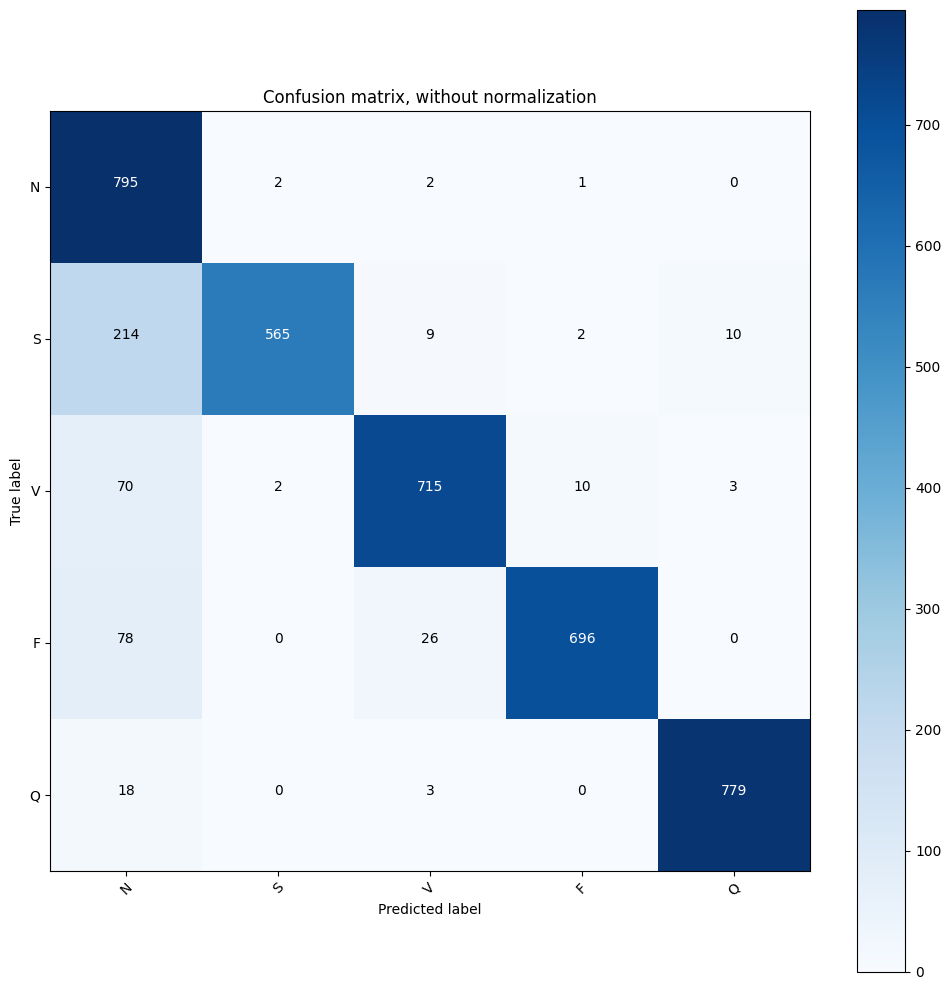

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_dense.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()